## <center>Sales Opportunity Scoring Using scikit-learn</center>

## <center>Submitted By</center>

## <center>Ben Karabinus</center>

## <center>University of Denver</center>

## <center> Ritchie School of Engineering and Computer Science</center>

## <center>COMP 4448, Data Science Tools 2</center>

## <center>Summer Quarter 2022</center>

## _Opportunity Scoring Motivation_

A sales opportunity can be defined as a sales account that has been qualified as showing legitimate interest in purchasing a product or service from another business entity. Businesses with sales departments commonly track opportunities through software using a customer relationship management system (CRM). CRM applications store attributes related to opportunities in an organization's sales pipeline. Attributes regarding a given opportunity may include what products or services are potentially being purchased, details of any existing relationship with the individual or company listed on an opportunity record, or which sales representative owns a given opportunity. Sales teams use this information to determine which pursuits have the greatest likelihood of success and therefore should be pursued more aggressively. This project tests the effectiveness of predicitng win or loss for sales opportunities currently in an organization's pipeline using classification algorithms. The following algorithms will be applied to the data using the __[scikit-learn module](https://scikit-learn.org/stable/)__ available for import in Python 3.x:

- Support Veector CLassification
- Decision Tree Classification
- Random Forest Classification
- Logistic Regression

## *Project Setup and Data Import*

In [170]:
"""import the necessary libraries"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msngo
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [171]:
"""load the opportunities data"""

opportunities = pd.read_csv('opportunities.csv')
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2593 entries, 0 to 2592
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   opportunity_id                  2593 non-null   object 
 1   Entity_ID                       2593 non-null   int64  
 2   Est_Revenue                     2593 non-null   float64
 3   Annual_Revenue                  2593 non-null   int64  
 4   days_active                     2593 non-null   float64
 5   PFY_RSM_Services_Spend          2593 non-null   float64
 6   CFY_RSM_Services_Spend          2593 non-null   float64
 7   No_of_Employees                 2593 non-null   int64  
 8   Probability                     2593 non-null   object 
 9   Lead_Source                     2593 non-null   object 
 10  Private_Equity                  2593 non-null   object 
 11  Open_Revenue                    2593 non-null   float64
 12  Type                            25

## *Sales Opportunity Data*

The dataset used for this project was exported from Dynamics CRM, a cloud-hosted customer relationship management built on Microsoft Dataverse. Records describe opportunities created by sales professionals that work for a consulting firm specializing in the implementation and management of business applications. Sales pursuits range from full scale Enterprise Resource Planning (ERP) software implementations costing millions of dollars to short-term agreements for providing consulting services.

Data was exported from Dynamics CRM as an Excel workbook with the initial record set consisting of 3894 records including over 100 features for each sales opportunity. This was then reduced to 66 relevant features by consulting stakeholders working for the organization where the data was sourced. Following this reduction, the dataset was converted to a binary format (pickle file) to preserve proper data types when read into Pandas Dataframes for further analysis. Records include attributes obtained using the North American Industry Classification Service __[(NAICS)](https://www.census.gov/naics/)__. To obtain further information regarding NAICS attributes listed on opportunity records, an Excel export was taken from a separate NAICS data store and merged with the primary dataset. 

Due to the large number of features included in the initial export a description of each field will be given following feature selection.

## *Data Preprocessing: Part 1*

 *Objectives*

 - Clean column names and reset dataframe index to unique value or opportunity_id and entity_id.
 - Drop records that were active for less than 10 days.
 - Drop feature revenue_size
 - Create a new feature specifying ratio of record completeness.
 - Check for missing data, determine the missingness mechanism.
 - Handle missinging data appropriately.
 - Create a new feature specifying RSM segment (market segment).
 - Convert categorical features to category data type.
 - Split data into training and test sets

### Clean column names and reset dataframe index to unique value of opportunity_id and entity_id

In [172]:
"""clean column names, opportunities dataframe"""

# get column names
opportunities.columns = opportunities.columns.str.lower()

In [173]:
"""set dataframe index to unique combination of opportunity_id and entity_id"""

opportunities.set_index(['opportunity_id', 'entity_id'], inplace=True)

Drop records that were active for less than 10 days

In [174]:
opportunities = opportunities[opportunities['days_active'] > 9]

Drop feature revenue_size

In [175]:
"""drop the revenue_size feature"""

opportunities.drop(columns=['revenue_size'], inplace=True)

Create a new feature specifying record completeness

In [176]:
"""count missing values in each column, represent new attribute as ratio of complete attributes per record"""

# transform values "_missing_" to None
opportunities = opportunities.applymap(lambda x : None if x == "_missing_" else x)
# get number of columns prior to transformation
denominator = opportunities.shape[1]
# count number of missing values per row and assign to feature record_completeness
opportunities.insert(loc=opportunities.shape[1]-1, column='record_completeness', value=opportunities.isnull().sum(axis=1))
# express record completeness as percentage of complete attributes per record
opportunities['record_completeness'] = opportunities['record_completeness'].apply(lambda x: 1-(x/denominator))

Check for missing data, determine the missingness mechanism

In [177]:
"print a ratio of missing values by feature"

opportunities.isnull().mean()

est_revenue                       0.000000
annual_revenue                    0.000000
days_active                       0.000000
pfy_rsm_services_spend            0.000000
cfy_rsm_services_spend            0.000000
no_of_employees                   0.000000
probability                       0.076110
lead_source                       0.000000
private_equity                    0.112579
open_revenue                      0.000000
type                              0.000000
industry_sector                   0.000000
microsoft_enterprise_agreement    0.405391
record_completeness               0.000000
won                               0.000000
dtype: float64

<AxesSubplot:>

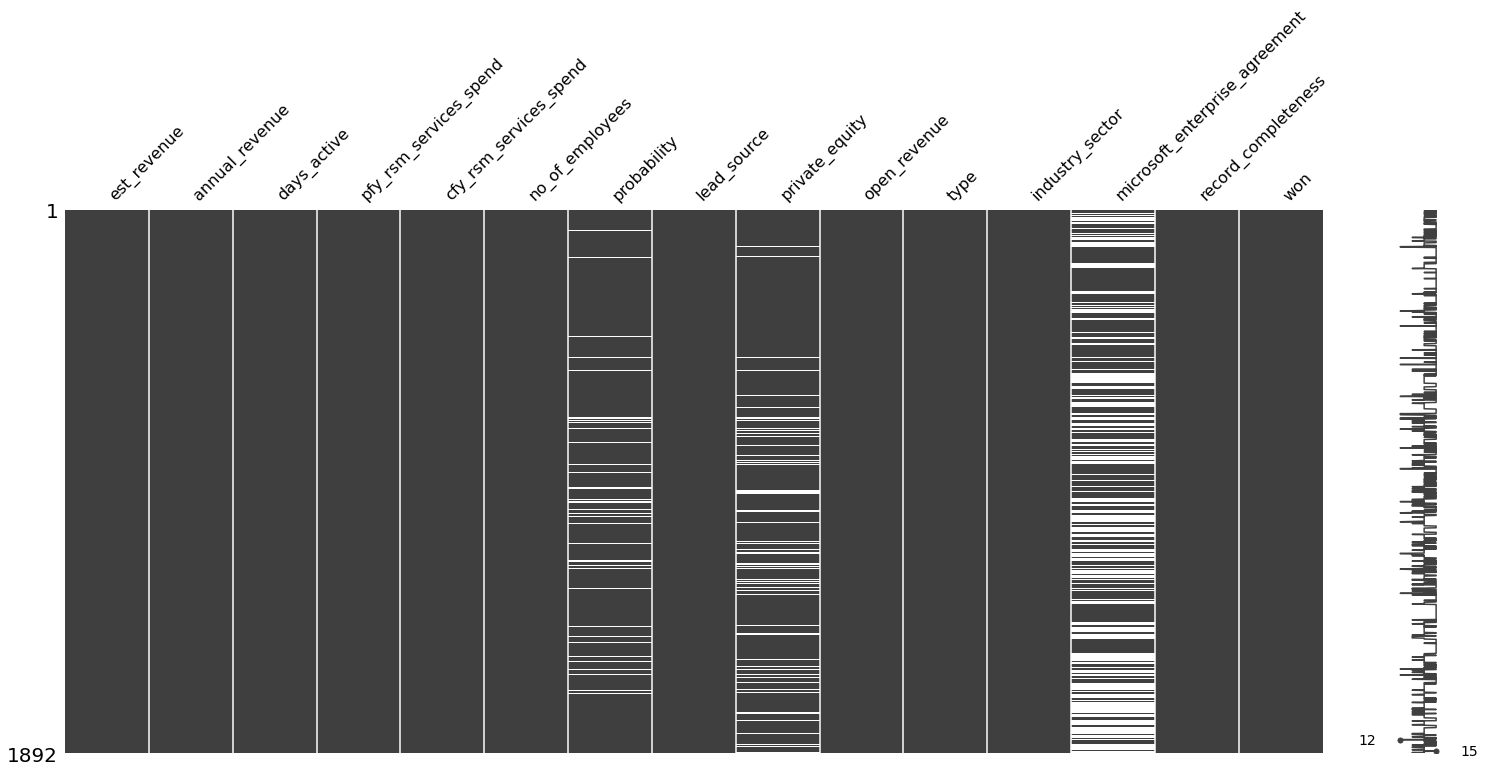

In [178]:
"""
print missing matrix for data using missingo module
missing matrix will provide high-level view of missingness mechanism (MCAR, MAR, NMAR)
"""

msngo.matrix(opportunities)

Data appears to be either missing completely at random (MCAR) or missing at random (MAR). Features missing 30% or more observations will be dropped. Mode imputation will be applied to discrete features missing between 5% and 29% of observations.

In [179]:
"""handle missing data"""

# drop microsoft_enterprise_agreement_feature
opportunities.drop(columns=['microsoft_enterprise_agreement'], inplace=True)
# apply mode imputation to the probability feature
opportunities['probability'].fillna(opportunities['probability'].mode()[0], inplace=True)
# apply mode imputation to the private_equity feature
opportunities['private_equity'].fillna(opportunities['private_equity'].mode()[0], inplace=True)
# print sum of null values to verify replacement
opportunities.isnull().sum()

est_revenue               0
annual_revenue            0
days_active               0
pfy_rsm_services_spend    0
cfy_rsm_services_spend    0
no_of_employees           0
probability               0
lead_source               0
private_equity            0
open_revenue              0
type                      0
industry_sector           0
record_completeness       0
won                       0
dtype: int64

Create a new feature specifying RSM segment (market segment)

In [180]:
"""create new feature revenue_size as a categroical representation of estimated revenue (market segment) for a given opportunity"""

opportunities.insert(loc=opportunities.shape[1]-1, column='segment', value=pd.cut(x=opportunities['annual_revenue'],
                    bins=[-1, 5000000, 30000000, 100000000, 1000000000, 1000000000000],
                    labels=['below_middle', 'lower_middle','middle_market', 'upper_middle', 'up_market']))

In [181]:
opportunities.isnull().sum()

est_revenue               0
annual_revenue            0
days_active               0
pfy_rsm_services_spend    0
cfy_rsm_services_spend    0
no_of_employees           0
probability               0
lead_source               0
private_equity            0
open_revenue              0
type                      0
industry_sector           0
record_completeness       0
segment                   0
won                       0
dtype: int64

### Convert categorical features to category data type

In [182]:
"""convert categorical features to proper data type"""

# get index of categorical features
categorical_idx = opportunities.select_dtypes(include=['bool', 'object', 'category'])
# convert to categorical dtype
for feature in categorical_idx:
    opportunities[feature] = opportunities[feature].astype('category')
# verify conversion
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1892 entries, ('8549a452-2d9b-e711-8118-005056ad09ed', 7787042) to ('d3ab2c66-ec15-e711-8114-005056ad6943', 7785141)
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   est_revenue             1892 non-null   float64 
 1   annual_revenue          1892 non-null   int64   
 2   days_active             1892 non-null   float64 
 3   pfy_rsm_services_spend  1892 non-null   float64 
 4   cfy_rsm_services_spend  1892 non-null   float64 
 5   no_of_employees         1892 non-null   int64   
 6   probability             1892 non-null   category
 7   lead_source             1892 non-null   category
 8   private_equity          1892 non-null   category
 9   open_revenue            1892 non-null   float64 
 10  type                    1892 non-null   category
 11  industry_sector         1892 non-null   category
 12  record_completeness     1892 non-null  

Split data into training and test sets

In [183]:
"""split data into training and test"""

X = opportunities.iloc[:, :-1]
y = opportunities.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

## *Exploratory Data Analysis*

*Objectives*

- Quantitative Analysis
    - Print descriptive staistics for numeric features.
    - Print the frequency distribution of won vs lost opportunities.
    - Print the frequency distribution of won vs lost opportunities by market segment
    - Print the frequency distribution of won vs lost opportunities by relationship type (Existing Relationship - New Business, Existing Relationship - Renewal, New Relationship - New Business)
- Visual Analysis
    - Plot distribution of continuous features
    - Plot correlation heatmap of numeric features
    - Create a bar plot of wins vs losses for opportunity records
    - Create a bar plot of wins vs losses for opportunity records binned by market segment
    - Create a scatter plot of days_active vs estimated_revenue with hue to signify if data points were won or lost opportunities

### Quantitative Analysis

Print descriptive staistics for numeric features

In [184]:
"""print descriptive statistics for numeric features in the training set"""

# get numeric features in the data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
# print descriptive statistics
X_train[numeric_features].agg(func=['min', 'median', 'mean', 'max', 'var', 'std', 'skew', 'kurt'])

,est_revenue,annual_revenue,days_active,pfy_rsm_services_spend,cfy_rsm_services_spend,no_of_employees,open_revenue,record_completeness
min,0.000000e+00,0.000000e+00,9.001806,-5.294611e+04,-2.138515e+04,0.000000e+00,0.000000e+00,0.785714
median,1.500000e+05,1.078796e+08,89.536510,3.133526e+04,2.684397e+04,3.500000e+02,0.000000e+00,1.000000
mean,6.170179e+05,3.908836e+08,161.835511,4.656233e+05,4.875612e+05,1.601200e+03,3.757388e+05,0.958351
max,1.404744e+07,1.115839e+10,1554.609850,6.214816e+06,7.308499e+06,9.500000e+04,7.000000e+06,1.000000
var,1.297986e+12,9.615881e+17,39990.573259,1.079958e+12,1.489477e+12,2.593910e+07,1.259106e+12,0.002267
std,1.139292e+06,9.806060e+08,199.976432,1.039210e+06,1.220442e+06,5.093044e+03,1.122099e+06,0.047613
skew,4.229181e+00,7.687536e+00,2.455915,3.155266e+00,3.772497e+00,9.879531e+00,4.168915e+00,-0.989650
kurt,2.855169e+01,7.380920e+01,7.541260,1.042054e+01,1.557237e+01,1.348600e+02,1.901914e+01,0.941444


In [185]:
"""print descriptive statistics for numeric features in the test set"""

# get numeric features in the data
numeric_features = X_test.select_dtypes(include=['int64', 'float64']).columns
# print descriptive statistics
X_test[numeric_features].agg(func=['min', 'median', 'mean', 'max', 'var', 'std', 'skew', 'kurt'])

,est_revenue,annual_revenue,days_active,pfy_rsm_services_spend,cfy_rsm_services_spend,no_of_employees,open_revenue,record_completeness
min,-1.000000e+00,0.000000e+00,9.169502,-5.294611e+04,-1.931830e+04,0.000000e+00,0.000000e+00,0.785714
median,1.053220e+05,1.008343e+08,83.395341,3.133526e+04,2.458600e+04,3.400000e+02,0.000000e+00,0.928571
mean,5.273012e+05,4.498652e+08,167.432716,4.738271e+05,4.591134e+05,1.473803e+03,3.068872e+05,0.955734
max,8.337520e+06,3.000000e+10,1376.713785,6.214816e+06,7.308499e+06,7.500000e+04,7.000000e+06,1.000000
var,9.182459e+11,2.683740e+18,44920.979767,1.000458e+12,1.169900e+12,1.943249e+07,8.523591e+11,0.002302
std,9.582515e+05,1.638212e+09,211.945700,1.000229e+06,1.081619e+06,4.408230e+03,9.232330e+05,0.047982
skew,3.483618e+00,1.233370e+01,2.484082,2.886949e+00,3.785400e+00,1.003004e+01,4.714396e+00,-0.870751
kurt,1.714401e+01,1.970290e+02,7.260569,8.381331e+00,1.699904e+01,1.441467e+02,2.663394e+01,0.616419


Print the frequency distribution of won vs lost opportunities.

In [186]:
"""print ratio of won vs lost opportunities in the training data"""

y_train.value_counts(normalize=True)

won
0      0.511329
1      0.488671
dtype: float64

In [187]:
"""print ratio of won and lost opportunities in the test data"""

y_test.value_counts(normalize=True)

won
0      0.510563
1      0.489437
dtype: float64

Print the frequency distribution of won vs lost opportunities by market segment

In [188]:
"""print ratio of won and lost opportunities by segment in the training set"""


pd.merge(X_train, y_train, left_index=True, right_index=True, how='inner')[['segment', 'won']]\
         .groupby(by='segment')[['segment', 'won']].value_counts(normalize=True)

segment        won
below_middle   1      0.509009
               0      0.490991
lower_middle   0      0.529412
               1      0.470588
middle_market  0      0.580357
               1      0.419643
upper_middle   0      0.506993
               1      0.493007
up_market      1      0.573529
               0      0.426471
dtype: float64

In [189]:
"""print ratio of won and lost opportunities by segment in the test set"""


pd.merge(X_test, y_test, left_index=True, right_index=True, how='inner')[['segment', 'won']]\
         .groupby(by='segment')[['segment', 'won']].value_counts(normalize=True)

segment        won
below_middle   1      0.509434
               0      0.490566
lower_middle   0      0.600000
               1      0.400000
middle_market  0      0.566667
               1      0.433333
upper_middle   1      0.513043
               0      0.486957
up_market      1      0.578947
               0      0.421053
dtype: float64

Print the frequency distribution of won vs lost opportunities by relationship type (Existing Relationship - New Business, Existing Relationship - Renewal, New Relationship - New Business)

In [190]:
"""print ratio of won and lost opportunities by type in the training set"""


pd.merge(X_train, y_train, left_index=True, right_index=True, how='inner')[['type', 'won']]\
         .groupby(by='type')[['type', 'won']].value_counts(normalize=True)

type                                  won
Existing Relationship - New Business  1      0.608466
                                      0      0.391534
Existing Relationship - Renewal       0      0.528351
                                      1      0.471649
New Relationship - New Business       0      0.677507
                                      1      0.322493
dtype: float64

In [191]:
"""print ratio of won and lost opportunities by type in the test set"""


pd.merge(X_test, y_test, left_index=True, right_index=True, how='inner')[['type', 'won']]\
         .groupby(by='type')[['type', 'won']].value_counts(normalize=True)

type                                  won
Existing Relationship - New Business  1      0.573944
                                      0      0.426056
Existing Relationship - Renewal       0      0.559441
                                      1      0.440559
New Relationship - New Business       0      0.631206
                                      1      0.368794
dtype: float64

### Visual Analysis

Plot distribution of continuous features

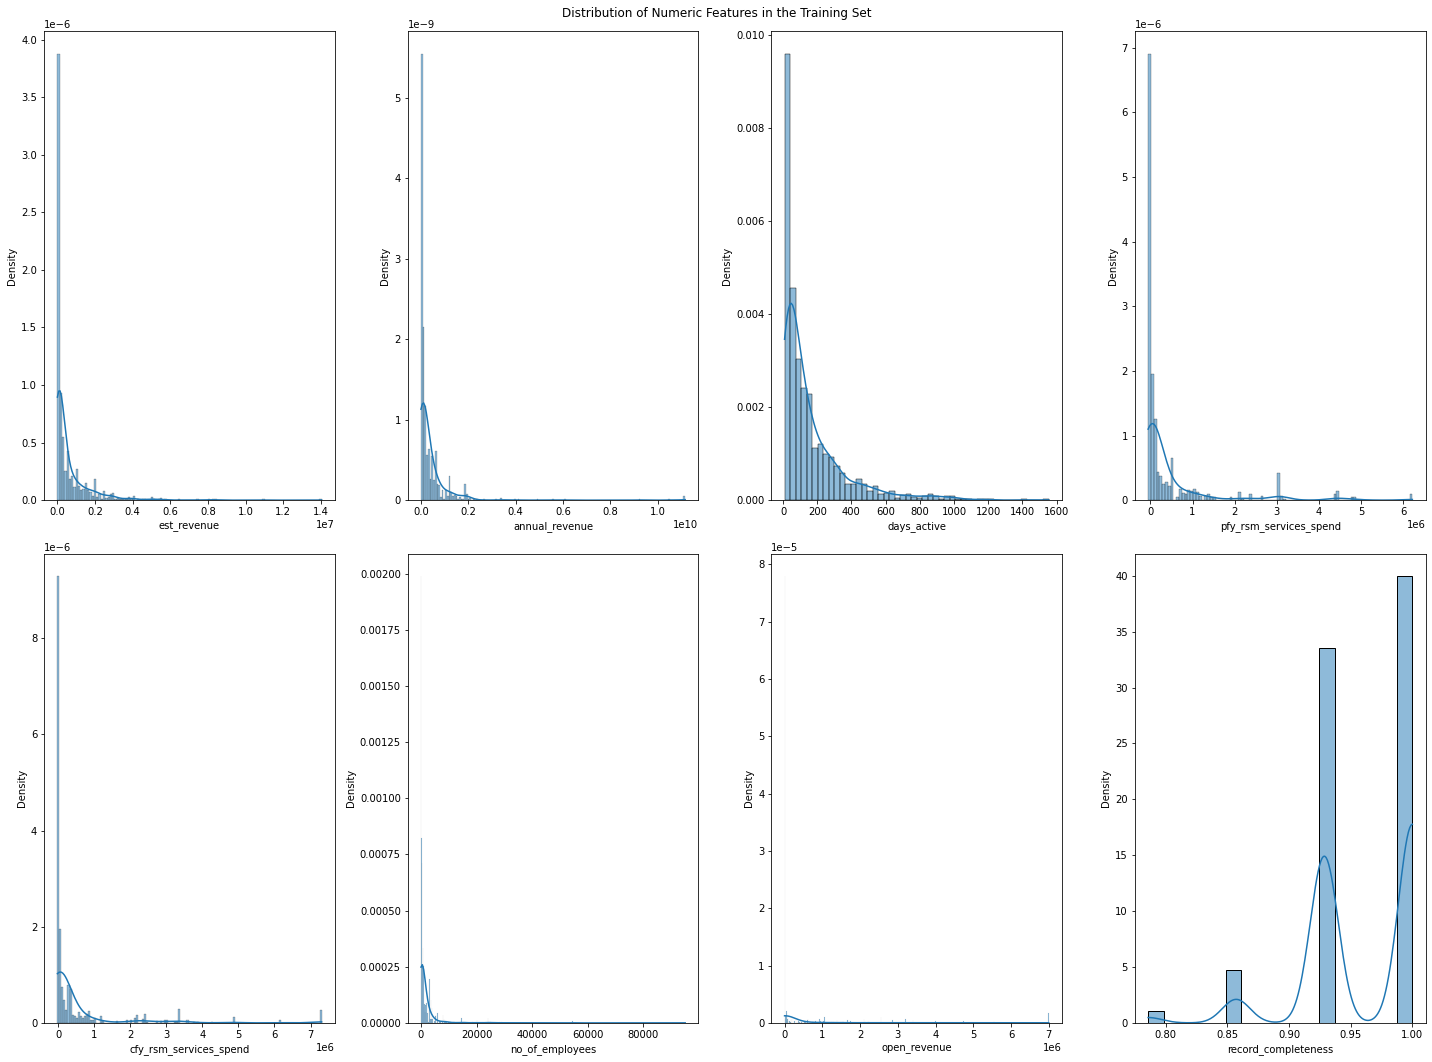

In [192]:
"""plot the distribution numeric features in the training set"""

fig, ax = plt.subplots(2, 4, figsize=(20, 15))
sns.histplot(data=X_train, x='est_revenue', stat='density', kde=True, ax=ax[0, 0])
sns.histplot(data=X_train, x='annual_revenue', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(data=X_train, x='days_active', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(data=X_train, x='pfy_rsm_services_spend', stat='density', kde=True, ax=ax[0,3])
sns.histplot(data=X_train, x='cfy_rsm_services_spend', stat='density', kde=True, ax=ax[1, 0])
sns.histplot(data=X_train, x='no_of_employees', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(data=X_train, x='open_revenue', stat='density', kde=True, ax=ax[1, 2])
sns.histplot(data=X_train, x='record_completeness', stat='density', kde=True, ax=ax[1,3])

#plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of Numeric Features in the Training Set')
plt.tight_layout()

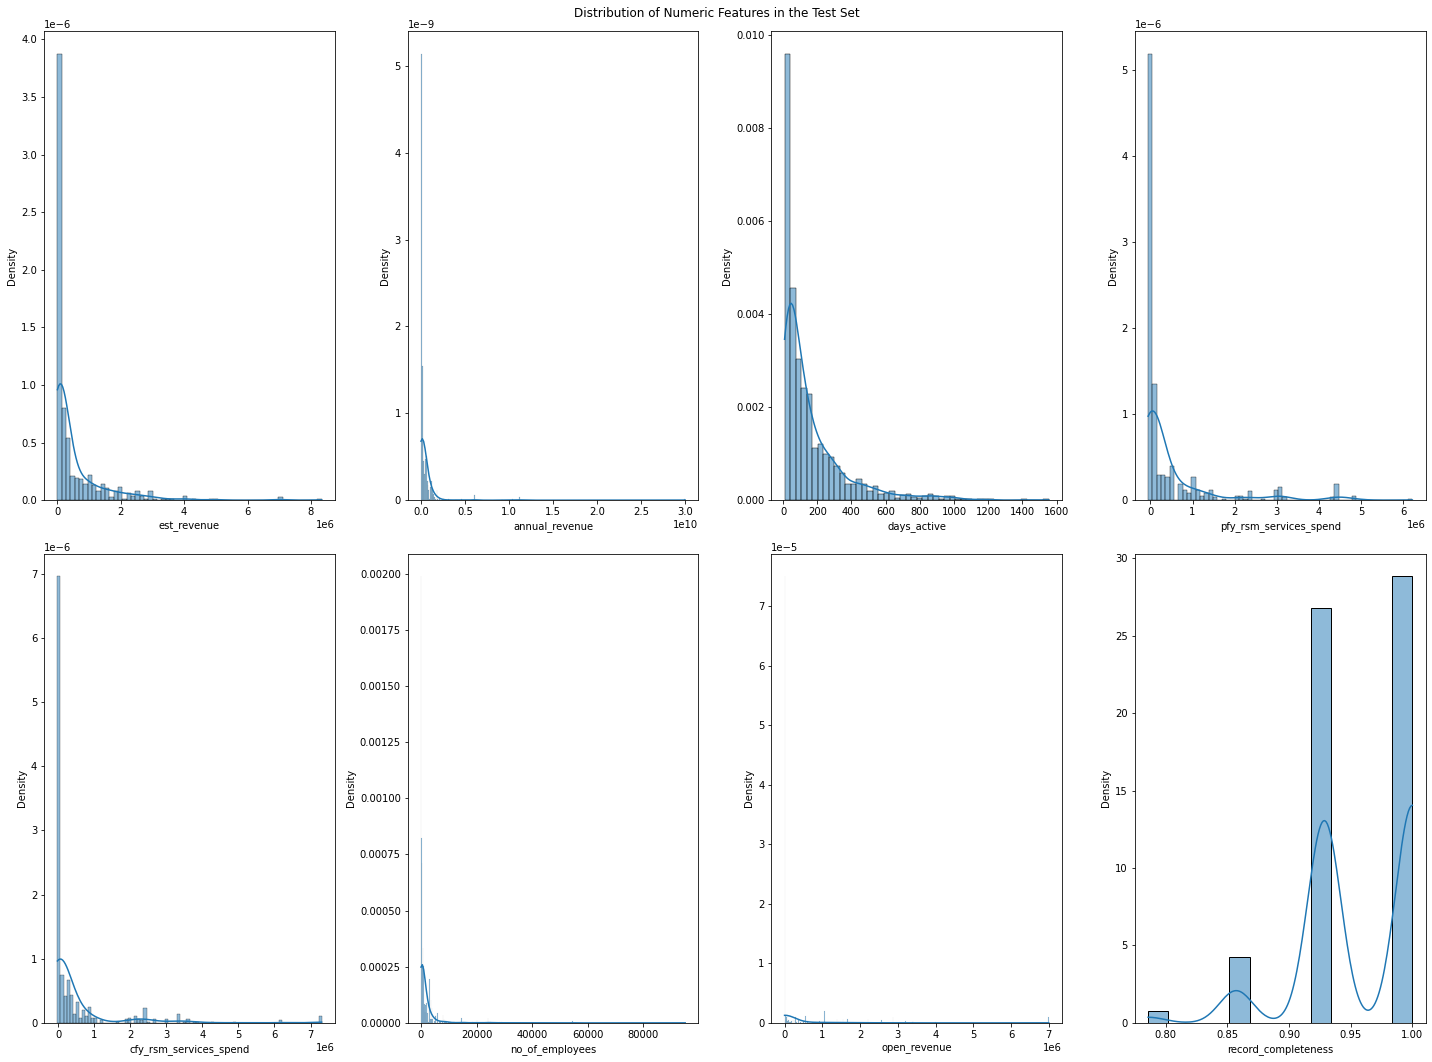

In [193]:
"""plot the distribution numeric features in the test set"""

fig, ax = plt.subplots(2, 4, figsize=(20, 15))
sns.histplot(data=X_test, x='est_revenue', stat='density', kde=True, ax=ax[0, 0])
sns.histplot(data=X_test, x='annual_revenue', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(data=X_train, x='days_active', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(data=X_test, x='pfy_rsm_services_spend', stat='density', kde=True, ax=ax[0,3])
sns.histplot(data=X_test, x='cfy_rsm_services_spend', stat='density', kde=True, ax=ax[1, 0])
sns.histplot(data=X_train, x='no_of_employees', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(data=X_test, x='open_revenue', stat='density', kde=True, ax=ax[1, 2])
sns.histplot(data=X_test, x='record_completeness', stat='density', kde=True, ax=ax[1,3])

#plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of Numeric Features in the Test Set')
plt.tight_layout()

Plot correlation heatmap of numeric features

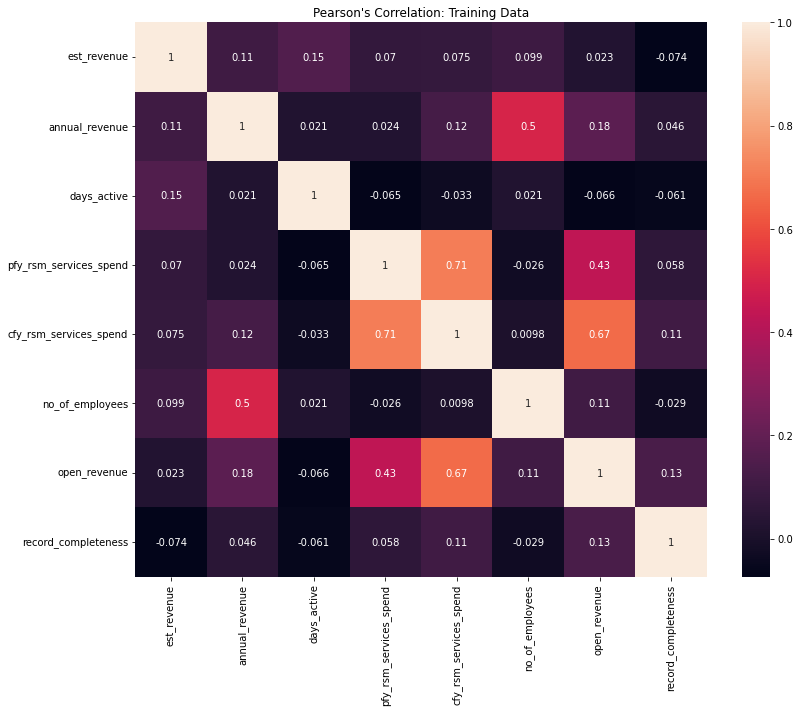

In [194]:
"""plot correlation, training set"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(X_train[numeric_features].corr(), annot=True)
plt.title('Pearson\'s Correlation: Training Data')
plt.tight_layout()
plt.show()

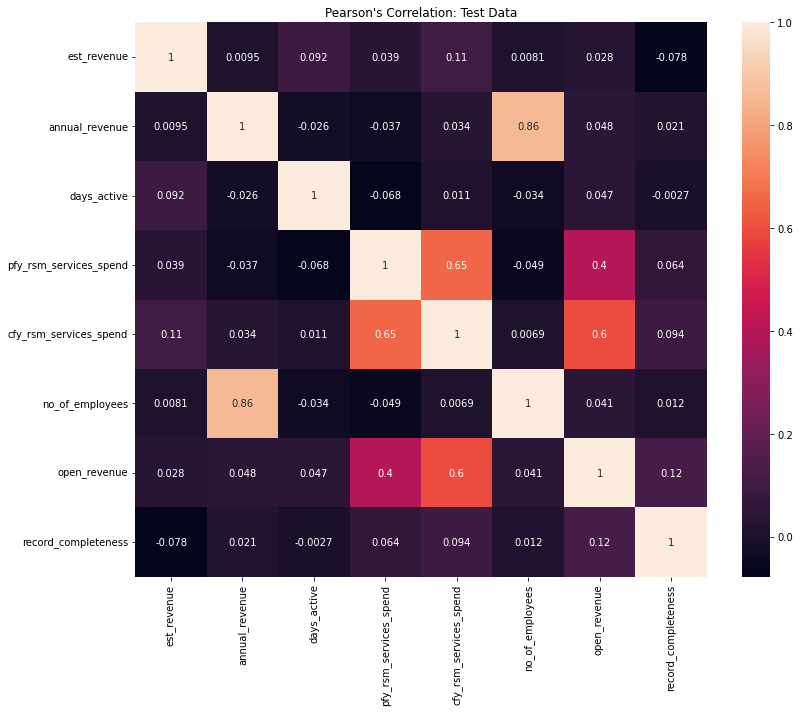

In [195]:
"""plot correlation, test set"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(X_test[numeric_features].corr(), annot=True)
plt.title('Pearson\'s Correlation: Test Data')
plt.tight_layout()
plt.show()

Create a bar plot of wins vs losses for opportunity records

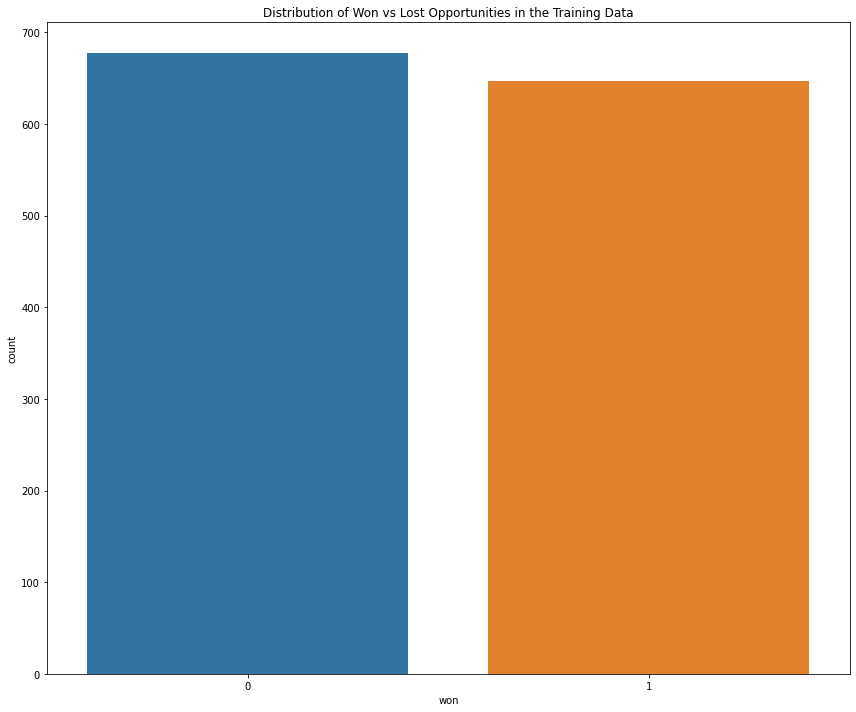

In [196]:
"""bar plot of wins vs losses in the training data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=y_train, x='won')
plt.title('Distribution of Won vs Lost Opportunities in the Training Data')
plt.tight_layout()
plt.show()

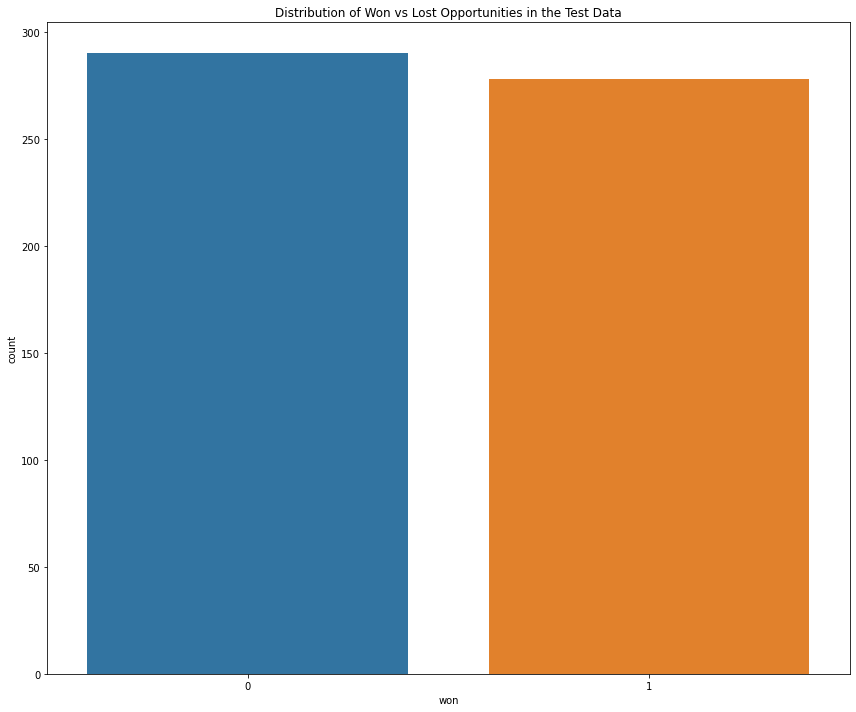

In [197]:
"""bar plot of wins vs losses in the test data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=y_test, x='won')
plt.title('Distribution of Won vs Lost Opportunities in the Test Data')
plt.tight_layout()
plt.show()

Create a bar plot of wins vs losses for opportunity records binned by market segment

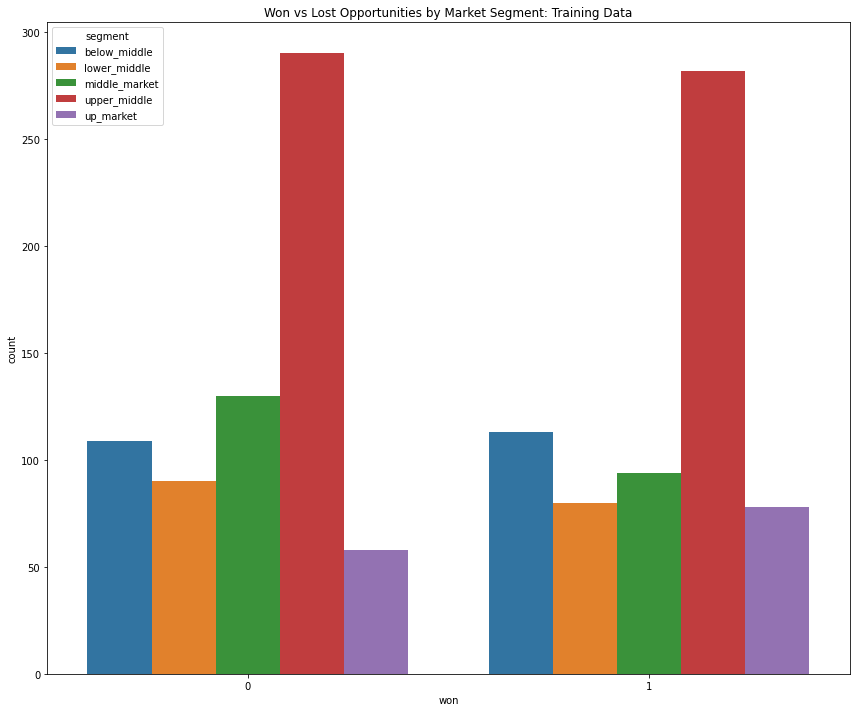

In [198]:
"""distribution of wins vs losses binned by segment, training data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=pd.merge(X_train, y_train, left_index=True, right_index=True, how='inner')[['segment', 'won']],
              x='won', hue='segment')
plt.title('Won vs Lost Opportunities by Market Segment: Training Data')
plt.tight_layout()
plt.show()

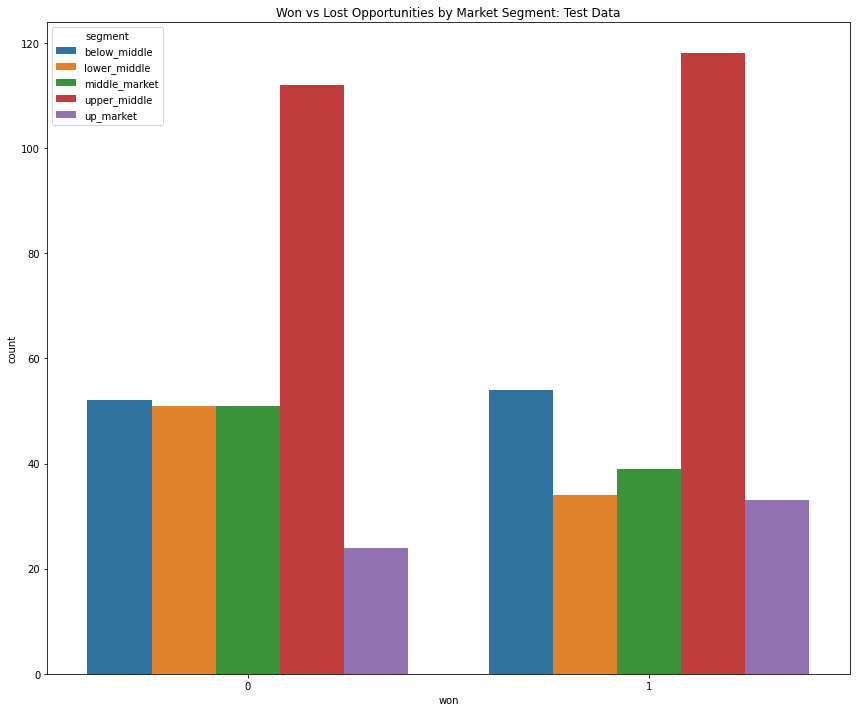

In [199]:
"""distribution of wins vs losses binned by segment, test data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=pd.merge(X_test, y_test, left_index=True, right_index=True, how='inner')[['segment', 'won']],
              x='won', hue='segment')
plt.title('Won vs Lost Opportunities by Market Segment: Test Data')
plt.tight_layout()
plt.show()

Create a scatter plot of days_active vs estimated_revenue with hue to signify if data points were won or lost opportunities

Text(0.5, 0.98, 'Scatter of Days Active vs Estimated Revenue: Training Data')

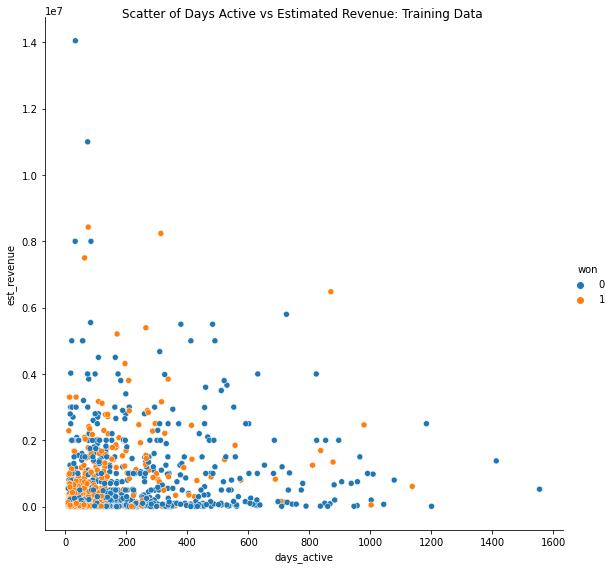

In [200]:
"""scatter of days_active vs est_revenue colored by win or loss, training data"""

plot = sns.relplot(data=pd.merge(X_train, y_train, left_index=True, right_index=True, how='inner')[['days_active', 'est_revenue', 'won']],
             x='days_active', y='est_revenue', hue='won', height=8, aspect=1.0)
plot.fig.suptitle('Scatter of Days Active vs Estimated Revenue: Training Data')

Text(0.5, 0.98, 'Scatter of Days Active vs Estimated Revenue: Test Data')

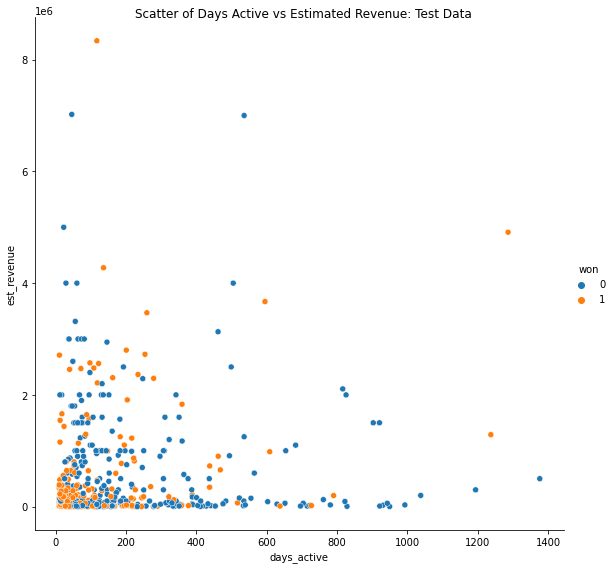

In [201]:
"""scatter of days_active vs est_revenue colored by win or loss, test data"""

plot = sns.relplot(data=pd.merge(X_test, y_test, left_index=True, right_index=True, how='inner')[['days_active', 'est_revenue', 'won']],
             x='days_active', y='est_revenue', hue='won', height=8, aspect=1.0)
plot.fig.suptitle('Scatter of Days Active vs Estimated Revenue: Test Data')

## *Model Construction and Evaluation*

*Objectives*

- Create a helper function to get the index of categorical and numeric features in the data.
- Construct models, tune select hyperparameters, and perform cross-validation on the training set. The following classification algorithms will be tested:
    - Support Vector Classification
    - Decision Tree Classification
    - Random Forest Classification
    - Logistic Regression 
- Apply further hyperparameter tuning to the best performing algorithm.
- Assess performance of the tuned model when applied to the test set.


### Create a helper function to get the index of categorical and numeric features in the data

In [202]:
"""helper function to return indeces of different datatypes in the feature set"""

def get_dtype_idx(data):

    # get numeric features index as list
    numeric_idx = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # get categroical features index as list
    categorical_idx = X_train.select_dtypes(include=['bool', 'object', 'category']).columns.tolist()

    # return indeces
    return numeric_idx, categorical_idx

### Construct models, select best features, and perform cross-validation on the training set

#### Support Vector Classification

In [203]:
"""apply model specific preprocessing to the data"""

# get index of categorical and numeric features in the data
numeric_idx, categorical_idx = get_dtype_idx(X_train)
# define a column transformer to prepare data for support vector classification
column_transformer = make_column_transformer(
                                             (OneHotEncoder(sparse=False), categorical_idx),
                                             (StandardScaler(), numeric_idx),
                                             remainder='passthrough'
)
# apply colmun transformer to training data and print dataframe head to view results
X_train_transformed = column_transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(data=X_train_transformed, columns=column_transformer.get_feature_names_out())

In [204]:
"""perform initial hyperparameter tuning for support vector classifier"""

params = {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
svc_grid_search = GridSearchCV(SVC(random_state=42), params, cv=3)
svc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the support vector classifier are:", svc_grid_search.best_params_)

The optimal hyperparameters for the support vector classifier are: {'gamma': 0.1, 'kernel': 'rbf'}


In [205]:
"""print the accuracy of the model applied to the training set"""

svc_grid_search.score(X_train_transformed, y_train)

0.8693353474320241

In [206]:
"""apply modle specific preprocessing to the test data and print classification report of the best estimator applied to the test set"""

# apply colmun transformer to test data and
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())
# get the best estimator from grid search
svc = svc_grid_search.best_estimator_
# apply the estimator to the test set and print results
svc.fit(X_test_transformed, y_test.to_numpy().flatten())
svc.score(X_test_transformed, y_test.to_numpy().flatten())

0.8626760563380281

#### Decision Tree Classification

In [207]:
"""apply model specific preprocessing to the data"""

# get index of categorical and numeric features in the data
numeric_idx, categorical_idx = get_dtype_idx(X_train)
# define a column transformer to prepare data for support vector classification
column_transformer = make_column_transformer(
                                             (OneHotEncoder(sparse=False), categorical_idx),
                                             (StandardScaler(), numeric_idx),
                                             remainder='passthrough'
)
# apply colmun transformer to training data and print dataframe head to view results
X_train_transformed = column_transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(data=X_train_transformed, columns=column_transformer.get_feature_names_out())

In [208]:
"""perform initial hyperparameter tuning for decision tree classifier"""

params = {'max_depth': range(1, 51), 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0]}
dtc_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=3)
dtc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the decision tree classifier are:", dtc_grid_search.best_params_)

The optimal hyperparameters for the decision tree classifier are: {'max_depth': 6, 'max_features': 1.0}


In [209]:
"""print the accuracy of the model applied to the training set"""

dtc_grid_search.score(X_train_transformed, y_train)

0.8678247734138973

In [210]:
"""apply modle specific preprocessing to the test data and print classification report of the best estimator applied to the test set"""

# apply colmun transformer to test data and
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())
# get the best estimator from grid search
dtc = dtc_grid_search.best_estimator_
# apply the estimator to the test set and print results
dtc.fit(X_test_transformed, y_test.to_numpy().flatten())
dtc.score(X_test_transformed, y_test.to_numpy().flatten())

0.8785211267605634

### Random Forest Classification

In [211]:
"""apply model specific preprocessing to the data"""

# get index of categorical and numeric features in the data
numeric_idx, categorical_idx = get_dtype_idx(X_train)
# define a column transformer to prepare data for support vector classification
column_transformer = make_column_transformer(
                                             (OneHotEncoder(sparse=False), categorical_idx),
                                             (StandardScaler(), numeric_idx),
                                             remainder='passthrough'
)
# apply colmun transformer to training data and print dataframe head to view results
X_train_transformed = column_transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(data=X_train_transformed, columns=column_transformer.get_feature_names_out())

In [212]:
"""apply grid search cross validation with random forest classifier and extract the best parameters"""

params = {'max_depth': range(1, 31), 'max_features': [0.2, 0.4, 0.6, 0.8, 1.0]}
rfc_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params,
                               scoring='accuracy', cv=3)
rfc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
best_params = rfc_grid_search.best_params_
print("The optimal hyperparameters for the random forest classifier are:", best_params)

The optimal hyperparameters for the random forest classifier are: {'max_depth': 18, 'max_features': 0.2}


In [213]:
"""print the accuracy of the model applied to the training set"""

rfc_grid_search.score(X_train_transformed, y_train)

0.9992447129909365

In [215]:
"""apply modle specific preprocessing to the test data and print classification report of the best estimator applied to the test set"""

# apply colmun transformer to test data and
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())
# get the best estimator from grid search
rfc = rfc_grid_search.best_estimator_
# apply the estimator to the test set and print results
rfc.fit(X_test_transformed, y_test.to_numpy().flatten())
rfc.score(X_test_transformed, y_test.to_numpy().flatten())

1.0

#### Logistic Regression

In [216]:
"""apply model specific preprocessing to the data"""

# get index of categorical and numeric features in the data
numeric_idx, categorical_idx = get_dtype_idx(X_train)
# define a column transformer to prepare data for support vector classification
column_transformer = make_column_transformer(
                                             (OneHotEncoder(sparse=False), categorical_idx),
                                             (StandardScaler(), numeric_idx),
                                             remainder='passthrough'
)
# apply colmun transformer to training data and print dataframe head to view results
X_train_transformed = column_transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(data=X_train_transformed, columns=column_transformer.get_feature_names_out())

In [217]:
"""apply grid search cross validation with logistic regression to extract the best parameters"""

params = {'C': [0.5, 1.0, 2.0, 5.0, 10.0]}
lr_grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=params, cv=3)
lr_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the logistic regression model are:", lr_grid_search.best_params_)

The optimal hyperparameters for the logistic regression model are: {'C': 5.0}


In [218]:
"""print the accuracy of the model applied to the training set"""

lr_grid_search.score(X_train_transformed, y_train)

0.8126888217522659

In [219]:
"""apply modle specific preprocessing to the test data and print classification report of the best estimator applied to the test set"""

# apply colmun transformer to test data and
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())
# get the best estimator from grid search
lr = lr_grid_search.best_estimator_
# apply the estimator to the test set and print results
lr.fit(X_test_transformed, y_test.to_numpy().flatten())
lr.score(X_test_transformed, y_test.to_numpy().flatten())

0.8133802816901409

### Apply further hyperparameter tuning to the best performing algorithm.

#### Random Forest Classifier Hyperparameter Tuning

In [221]:
"""apply further hyperparamter tuning to random forest classifier"""

# get index of categorical and numeric features in the data
numeric_idx, categorical_idx = get_dtype_idx(X_train)
# define a column transformer to prepare data for support vector classification
column_transformer = make_column_transformer((OneHotEncoder(sparse=False), categorical_idx), (StandardScaler(), numeric_idx),
                                             remainder='passthrough')
# get transformed training set
X_train_transformed = column_transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(data=X_train_transformed, columns=column_transformer.get_feature_names_out())
# define grid search to tune the model                                            
params = {'max_depth': range(1, 31), 'max_features': [0.2, 0.4, 0.6, 0.8, 1.0]}
rfc_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, cv=3, scoring='accuracy')
# fiit the grid
rfc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
# print the best params
print("The optimal hyperparameters for the random forest classifier are:", rfc_grid_search.best_params_)

The optimal hyperparameters for the random forest classifier are: {'max_depth': 18, 'max_features': 0.2, 'random_state': 42}


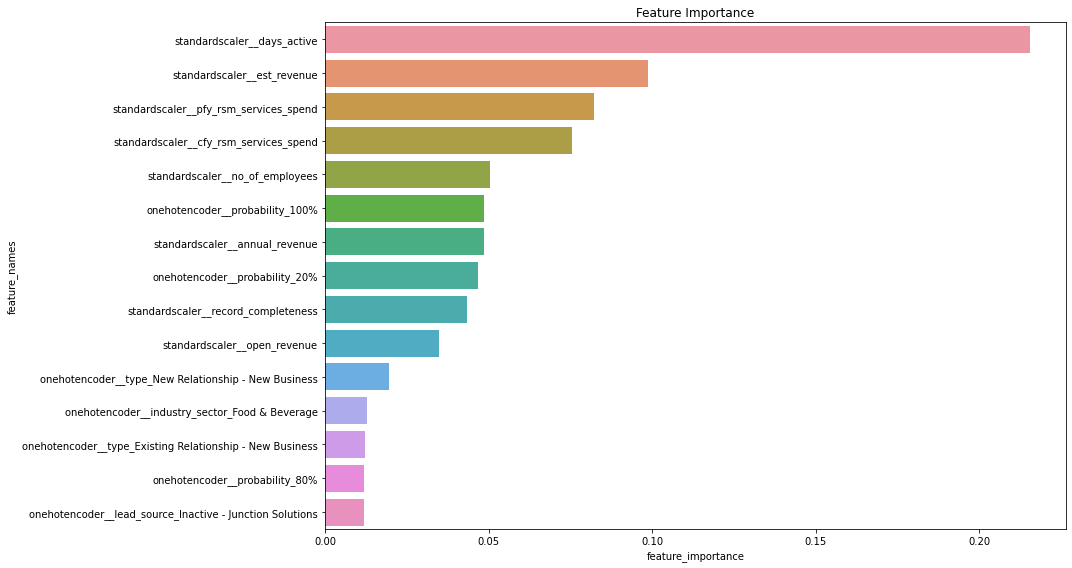

In [223]:
"""plot the featue importance of the random forest model"""

feature_importances = rfc_grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, X_train_transformed.columns))
#Create a DataFrame of results
model_results = {'feature_names':X_train_transformed.columns,'feature_importance':feature_importances}
model_results = pd.DataFrame(model_results)
# sort results by decreasing feature importance
model_results.sort_values(by=['feature_importance'], ascending=False,inplace=True)
# specify plot size
plt.figure(figsize=(15,8))
# create the plot using top 20% best features by importance
sns.barplot(x=model_results['feature_importance'][0:15], y=model_results['feature_names'][0:15])
# add labels
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [224]:
"""apply modle specific preprocessing to the test data and print classification report of the best estimator applied to the test set"""

# apply colmun transformer to test data and
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())
# get the best estimator from grid search
rfc = rfc_grid_search.best_estimator_
# apply the estimator to the test set and print classification report
rfc.fit(X_test_transformed, y_test.to_numpy().flatten())
y_test_pred = rfc.predict(X_test_transformed)
print(classification_report(y_test.to_numpy().flatten(), y_test.to_numpy().flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       278

    accuracy                           1.00       568
   macro avg       1.00      1.00      1.00       568
weighted avg       1.00      1.00      1.00       568

